In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import TrainingArguments, AutoTokenizer, HfArgumentParser
from utils.my_trainer import CustomTrainer
from utils.utils import my_compute_metrics,seed_everything
from typing import Optional
from dataclasses import dataclass, field
from model.my_model import MyCustomModel
from peft import LoraConfig
from datasets import load_dataset, concatenate_datasets
from utils.data_collator import MyDataCollatorForLanguageModelingTest

/bask/projects/p/phwq4930-gbm/Zeyu/asiw9691_conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'

def formatting_func(examples):
    question = examples["question"]
    answer = examples["answer"]
    if answer in ["yes","no"]:
        question += "Answer yes or no only!"
    text = f"<|Question|> {question}{tokenizer.eos_token}"
    examples["text"] = text
    return examples

def tokenize(element):
    outputs = tokenizer(
        element,
        add_special_tokens=True,
        truncation=True,
        padding=False,
        max_length=script_args.max_seq_length,
        return_overflowing_tokens=False,
        return_length=False,
    )

    return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

seed_everything(42)

In [3]:
# set up tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
tokenizer.truncation_side = 'left'

new_tokens = ['<|Question|>',  '<|Answer|>', '<Image>']  # 你要添加的特殊字符列表
num_added_toks = tokenizer.add_tokens(new_tokens)
new_tokens_ids = tokenizer.convert_tokens_to_ids(new_tokens)
print("new_tokens_ids: ", new_tokens_ids)

new_tokens_ids:  [32000, 32001, 32002]


In [4]:
# set up dataset
import ast

dataset_name_list = "CNX-PathLLM/PVQAClean"
dataset = []
for dataset_name in dataset_name_list.split(","):
    dataset.append(load_dataset(dataset_name, split="train", cache_dir="/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache"))
dataset = concatenate_datasets(dataset)
dataset = dataset.train_test_split(test_size=0.1)
dataset = dataset['test']
dataset = dataset.map(formatting_func, num_proc=4, remove_columns=["question"])

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
device = 'cuda'
model = MyCustomModel(False, 
                      "conch",
                      False, 
                      False, 
                      "mistralai/Mistral-7B-Instruct-v0.2", 
                      False, 
                      True, 
                      tokenizer,
                      new_tokens_ids[-1])

vision_encoder loading ...
llm loading ...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


In [6]:
from torch.utils.data import DataLoader

batch_size = 4  # 你可以根据需要调整批处理大小

data_collator = MyDataCollatorForLanguageModelingTest(tokenizer, model.image_processor)

In [7]:
def tokenize(element):
            outputs = tokenizer(
                # element[dataset_text_field] if not use_formatting_func else formatting_func(element),
                element,
                add_special_tokens=True,
                truncation=True,
                padding=False,
                max_length=256,
                return_overflowing_tokens=False,
                return_length=False,
            )

            return {"input_ids": outputs["input_ids"], "attention_mask": outputs["attention_mask"]}

tokenized_dataset = dataset.map(
            tokenize,
            batched=False,
            remove_columns=['text'],
            num_proc=4,
            batch_size=6,
            input_columns=['text'],
       )

dataloader_params = {
            "batch_size": 6,
            "collate_fn": data_collator,
        }

eval_dataloader = DataLoader(tokenized_dataset, **dataloader_params)

Map (num_proc=4): 100%|██████████| 752/752 [00:00<00:00, 1041.58 examples/s]


In [8]:
# params = torch.load("/bask/homes/a/asiw9691/PathVLM/source/PathLLM/PathClip_Mistral-7B_4dataset/checkpoint-750/global_step750/mp_rank_00_model_states.pt")
ckpt = "/bask/homes/a/asiw9691/PathVLM/source/PathLLM/Conch_Mistral_Instruct3/ckpt-800.bin"
model.load_state_dict(torch.load(ckpt, map_location=device))
model.to(device)

MyCustomModel(
  (vision_encoder): CoCa(
    (text): TextTransformer(
      (token_embedding): Embedding(32007, 768)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )
      (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (visual): VisualModel(
      (trunk): Visio

In [9]:
# 对于每个批次的数据
import numpy as np
from utils.eval_utils import calculate_f1score 
from tqdm import tqdm

close_ques_acc = 0
close_ques_num = 0
open_ques_f1 = []

for batch in tqdm(eval_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_masks = batch['attention_mask'].to(device)
    images = batch['image'].to(device)
    labels = batch['labels'].to(device)
    answers = batch['answers']

    # 执行模型推断
    res = model.generate(input_ids=input_ids,
                         attention_mask=attention_masks,
                         labels=labels,
                         image=images)
    
    for i in range(len(res)):
        if answers[i] in ['yes','no']:
            close_ques_num += 1
            if answers[i] in res[i]:
                close_ques_acc += 1
        else:
            f1_score = calculate_f1score(res[i], answers[i])
            open_ques_f1.append(f1_score)
    
open_ques_f1 = np.mean(open_ques_f1)
close_ques_acc = close_ques_acc/close_ques_num

100%|██████████| 126/126 [06:08<00:00,  2.93s/it]


In [12]:
open_ques_f1

0.05077007791766882

### For one image QA test

In [73]:
from PIL import Image

# question = "<|Question|> This is a renal carcinoma, what kind of subtype it is?"
# text = f"<|Question|> {question}{tokenizer.eos_token}"
# image = Image.open("./test_images/test1.jpeg")

i = 4
text = dataset[i]['text']
image = dataset[i]['image']
answer = dataset[i]['answer']

input_dic = tokenizer(text, return_tensors="pt")
map_image_data = model.image_processor(image)
input_dic["image"] = map_image_data

res = model.generate(input_ids = input_dic["input_ids"].to(device),
                    attention_mask = input_dic["attention_mask"].to(device),
                    labels = input_dic["input_ids"].to(device),
                    image = input_dic["image"].unsqueeze(0).to(device),
                )

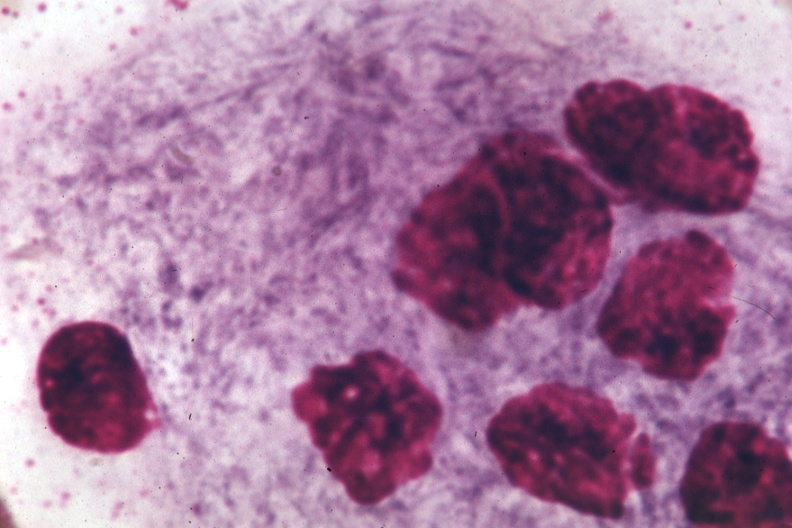

In [74]:
image

In [75]:
res

['<|Answer|> no, cystadenocarcinoma malignancy is not present. this case has a better prognosis because the tumor tends to behave in a less aggressive manner. no invasion of other tissues is visible, and it generally does not spread as easily as other types of cancer. however, these are just general observations and each case can vary widely.']

In [76]:
answer

'no'

In [1]:
!nvidia-smi

Wed Apr 17 21:53:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:4B:00.0 Off |                    0 |
| N/A   26C    P0              52W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--